1. Load in Imports required to run our code:

    - We decided to process our model through a Jupyter file so that we could run the models using out local GPU's. 

In [1]:
# Necessary imports for the project:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
from PIL import Image


c:\Users\Dillon\anaconda3\envs\enel645\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


2. Define transformers for augmenting our dataset and normalizing each image w.r.t. the ImageNet dataset:

    - preprecessing information that was used for resizing, center crop, and normalization can be found here: 
      https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [2]:
# Define transforms to augment our dataset to make it larger:
hz_transform = transforms.RandomHorizontalFlip(p=1.0)
vt_transform = transforms.RandomVerticalFlip(p=1.0)
rot_transform = transforms.RandomRotation(degrees=10)
jitter_transform = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
gauss_transform = transforms.GaussianBlur(kernel_size=3)
sharp_transform = transforms.RandomAdjustSharpness(sharpness_factor=1.5)
perspective_transform = transforms.RandomPerspective(distortion_scale=0.3, p=1.0)

# Define a transformer that will be applied on each image for preprocessing w.r.t. imageNet parameters:
preprocess_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),    # Pad images when necessary (reshape to square)
    transforms.CenterCrop(224),                                                 # Center crop size to 224x224 (to match ImageNet)
    transforms.ToTensor(),                                                      # Convert to tensor for PyTorch processing

    # Values used for normalization are the same as from the ImageNet dataset:
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

3. Importing dataset and augmenting training data:
    - Our dataset was downloaded off of Kaggle from the following link: https://www.kaggle.com/datasets/mdwaquarazam/agricultural-crops-image-classification
    - Two sets of data will be used for training 2 models
        - The first will use the original dataset with an 80%, 10%, 10% split for the training, validation ,and testing sets, respectively
        - The second will augment the training data with several transformers to increase the data size to compare with results from the first model that uses the original data
            - Information on each of the augmentation transformers can be found here: https://pytorch.org/vision/master/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
    - A transformer is applied to all images based on the recommended ImageNet normalization and preprocessing recommendations
    - Finally, we create training, validation, and testing datasets for both model variations (original and augmented):

In [3]:
#-------------------------------------------------------------------------------------------------
# Import the 'Agricultural-crops' images from a local folder.
# Split images from each classification label into individual testing, training, and validation sets.
# Combine these individual sets into single testing, training, and validation sets. 
#-------------------------------------------------------------------------------------------------

# Set the folder path for image dataset:
image_folder_1 = "Agricultural-crops"

# Get a list of the different agricultural crop classifications:
classifications_list_1 = os.listdir(image_folder_1)

# Output the list of crops that will be classified in this project:
print("Original dataset with no image augmentations for training:\n")
print("The following agricultural crops will be classified in this project:\n")
print(classifications_list_1,"\n")

# Initialize lists to store final combined training, validation, and testing sets:
combined_X_train_1 = []
combined_y_train_1 = []

combined_X_validation_1 = []
combined_y_validation_1 = []

combined_X_test_1 = []
combined_y_test_1 = []

# Iterate through all sub-folders in the "Agricultural-crops" folder:
for category_index_1, category_1 in enumerate(classifications_list_1):

    # Create path for the current sub-folder and store a list of the image file names in that folder: 
    curr_category_folder_1 = os.path.join(image_folder_1, category_1)
    curr_image_files_1 = os.listdir(curr_category_folder_1)

     # Initialize lists for storing image paths and the classification label associated to that path:
    curr_images_1 = []
    curr_classification_labels_1 = []

    for curr_image_name_1 in curr_image_files_1:
          
        # Create the full path for the current image: 
        curr_image_path_1 = os.path.join(curr_category_folder_1, curr_image_name_1)

        # load in the image:
        curr_image_1 = Image.open(curr_image_path_1).convert('RGB')

        # Apply the pre-processing transformation to original image, append it to the 'curr_images' list, and append the classification label for that image:
        curr_image_1 = preprocess_transform(curr_image_1)
        curr_images_1.append(curr_image_1)
        curr_classification_labels_1.append(category_index_1)      

    # Split the data for the current category into 80% training and the remaining 20% to be left over for validation and testing:
    curr_X_train_1, curr_X_temp_1, curr_y_train_1, curr_y_temp_1 = train_test_split(curr_images_1, curr_classification_labels_1, test_size=0.2, random_state=42)
    curr_X_validation_1, curr_X_test_1, curr_y_validation_1, curr_y_test_1 = train_test_split(curr_X_temp_1, curr_y_temp_1, test_size=0.5, random_state=42)

    # Extend the split data for the current category to the comined training, validation, and testing sets:
    combined_X_train_1.extend(curr_X_train_1)
    combined_y_train_1.extend(curr_y_train_1)

    combined_X_validation_1.extend(curr_X_validation_1)
    combined_y_validation_1.extend(curr_y_validation_1)

    combined_X_test_1.extend(curr_X_test_1)
    combined_y_test_1.extend(curr_y_test_1)

    # Print a summary for the current category:
    print("Category: ", category_1, ":\t\t Training samples = ", len(curr_X_train_1), ", Validation samples = ", len(curr_X_validation_1), ", Testing samples = ", len(curr_X_test_1))

# Print samples in each final set:
print("\nThe total number of training samples is: \t", len(combined_X_train_1))
print("The total number of validation samples is: \t", len(combined_X_validation_1))
print("The total number of testing samples is: \t", len(combined_X_test_1))


Original dataset with no image augmentations for training:

The following agricultural crops will be classified in this project:

['almond', 'banana', 'cardamom', 'Cherry', 'chilli', 'clove', 'coconut', 'Coffee-plant', 'cotton', 'Cucumber', 'Fox_nut(Makhana)', 'gram', 'jowar', 'jute', 'Lemon', 'maize', 'mustard-oil', 'Olive-tree', 'papaya', 'Pearl_millet(bajra)', 'pineapple', 'rice', 'soyabean', 'sugarcane', 'sunflower', 'tea', 'Tobacco-plant', 'tomato', 'vigna-radiati(Mung)', 'wheat'] 

Category:  almond :		 Training samples =  16 , Validation samples =  2 , Testing samples =  3
Category:  banana :		 Training samples =  24 , Validation samples =  3 , Testing samples =  4
Category:  cardamom :		 Training samples =  17 , Validation samples =  2 , Testing samples =  3
Category:  Cherry :		 Training samples =  25 , Validation samples =  3 , Testing samples =  4
Category:  chilli :		 Training samples =  18 , Validation samples =  2 , Testing samples =  3
Category:  clove :		 Training sampl

In [4]:
#-------------------------------------------------------------------------------------------------
# Import the 'Agricultural-crops' images from a local folder.
# Split images from each classification label into individual testing, training, and validation sets.
# Apply data augmentations to increase size of dataset and apply preprocessing transformations.
# Combine these individual sets into single testing, training, and validation sets. 
#-------------------------------------------------------------------------------------------------

# Set the folder path for image dataset:
image_folder_2 = "Agricultural-crops"

# Get a list of the different agricultural crop classifications:
classifications_list_2 = os.listdir(image_folder_2)

# Output the list of crops that will be classified in this project:
print("Modified dataset with 7 augmentations per image in the training set:\n")
print("The following agricultural crops will be classified in this project:\n")
print(classifications_list_2,"\n")

# Initialize lists to store final combined training, validation, and testing sets:
combined_X_train_2 = []
combined_y_train_2 = []

combined_X_validation_2 = []
combined_y_validation_2 = []

combined_X_test_2 = []
combined_y_test_2 = []

# Iterate through all sub-folders in the "Agricultural-crops" folder:
for category_index_2, category_2 in enumerate(classifications_list_2):

    # Create path for the current sub-folder and store a list of the image file names in that folder: 
    curr_category_folder_2 = os.path.join(image_folder_2, category_2)
    curr_image_files_2 = os.listdir(curr_category_folder_2)

     # Initialize lists for storing image paths and the classification label associated to that path:
    curr_images_2 = []
    curr_classification_labels_2 = []

    for curr_image_name_2 in curr_image_files_2:
          
        # Create the full path for the current image: 
        curr_image_path_2 = os.path.join(curr_category_folder_2, curr_image_name_2)

        # load in the image:
        curr_image_2 = Image.open(curr_image_path_2).convert('RGB')

        # Apply the pre-processing transformation to original image, append it to the 'curr_images' list, and append the classification label for that image:
        curr_image_2 = preprocess_transform(curr_image_2)
        curr_images_2.append(curr_image_2)
        curr_classification_labels_2.append(category_index_2)  

    # Split the data for the current category into 60% training (lower due to planned augmentation) and the remaining 40% to be left over for validation and testing:
    curr_X_train_2, curr_X_temp_2, curr_y_train_2, curr_y_temp_2 = train_test_split(curr_images_2, curr_classification_labels_2, test_size=0.4, random_state=42)
    curr_X_validation_2, curr_X_test_2, curr_y_validation_2, curr_y_test_2 = train_test_split(curr_X_temp_2, curr_y_temp_2, test_size=0.5, random_state=42)

    # Augment ONLY the training data:
    aug_X_train_2 = []
    aug_y_train_2 = []

    for curr_image_2, curr_label_2 in zip(curr_X_train_2, curr_y_train_2):
        
        # Append original training image to the augmented training set:
        aug_X_train_2.append(curr_image_2)
        aug_y_train_2.append(curr_label_2)

        # Run the image through the augmentation transformer to make 7 new images:
        curr_augmented_images_2 = [
            hz_transform(curr_image_2),
            vt_transform(curr_image_2),
            rot_transform(curr_image_2),
            jitter_transform(curr_image_2),
            gauss_transform(curr_image_2),
            sharp_transform(curr_image_2),
            perspective_transform(curr_image_2)
        ]

        # Apply the pre-processing transformation to all augmented training images, append them to the 'curr_images', and append the classification label for each image:
        for curr_augmented_image_2 in curr_augmented_images_2:
            curr_augmented_image_2 = preprocess_transform(transforms.ToPILImage()(curr_augmented_image_2))
            aug_X_train_2.append(curr_augmented_image_2)
            aug_y_train_2.append(curr_label_2)


    # Extend the split data for the current category to the comined training, validation, and testing sets:
    combined_X_train_2.extend(aug_X_train_2)
    combined_y_train_2.extend(aug_y_train_2)

    combined_X_validation_2.extend(curr_X_validation_2)
    combined_y_validation_2.extend(curr_y_validation_2)

    combined_X_test_2.extend(curr_X_test_2)
    combined_y_test_2.extend(curr_y_test_2)

    # Print a summary for the current category:
    print("Category: ", category_2, ":\t\t Training samples = ", len(aug_X_train_2), ", Validation samples = ", len(curr_X_validation_2), ", Testing samples = ", len(curr_X_test_2))

# Print samples in each final set:
print("\nThe total number of training samples is: \t", len(combined_X_train_2))
print("The total number of validation samples is: \t", len(combined_X_validation_2))
print("The total number of testing samples is: \t", len(combined_X_test_2))

Modified dataset with 7 augmentations per image in the training set:

The following agricultural crops will be classified in this project:

['almond', 'banana', 'cardamom', 'Cherry', 'chilli', 'clove', 'coconut', 'Coffee-plant', 'cotton', 'Cucumber', 'Fox_nut(Makhana)', 'gram', 'jowar', 'jute', 'Lemon', 'maize', 'mustard-oil', 'Olive-tree', 'papaya', 'Pearl_millet(bajra)', 'pineapple', 'rice', 'soyabean', 'sugarcane', 'sunflower', 'tea', 'Tobacco-plant', 'tomato', 'vigna-radiati(Mung)', 'wheat'] 

Category:  almond :		 Training samples =  96 , Validation samples =  4 , Testing samples =  5
Category:  banana :		 Training samples =  144 , Validation samples =  6 , Testing samples =  7
Category:  cardamom :		 Training samples =  104 , Validation samples =  4 , Testing samples =  5
Category:  Cherry :		 Training samples =  152 , Validation samples =  6 , Testing samples =  7
Category:  chilli :		 Training samples =  104 , Validation samples =  5 , Testing samples =  5
Category:  clove :		 

4. Visualize augmented data before running model if desired: (comment this out if you do not want to see dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


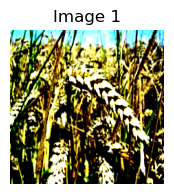

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


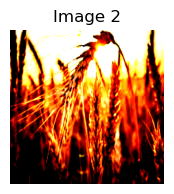

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


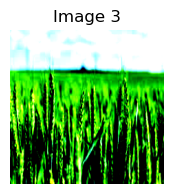

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


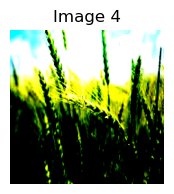

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


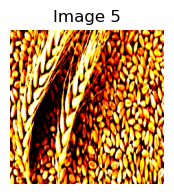

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


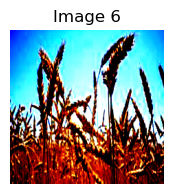

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


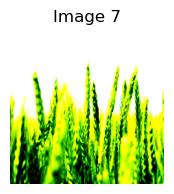

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


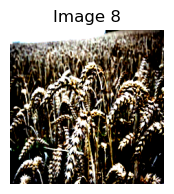

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


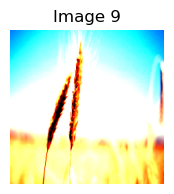

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


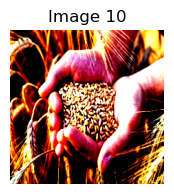

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


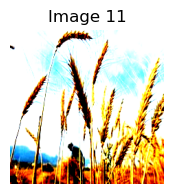

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


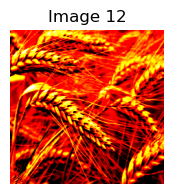

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


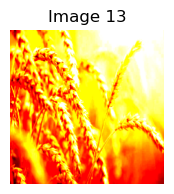

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


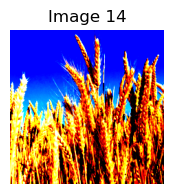

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


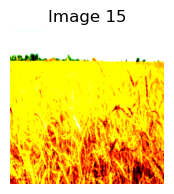

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


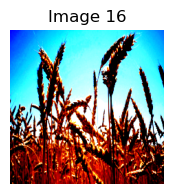

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


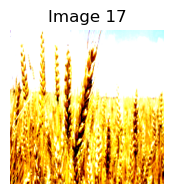

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


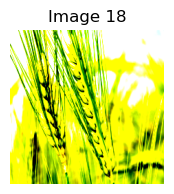

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


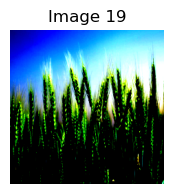

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


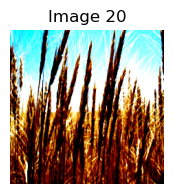

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


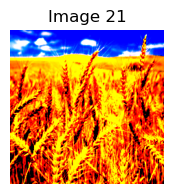

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


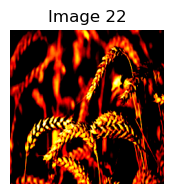

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


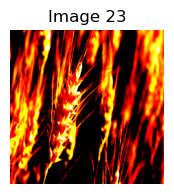

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


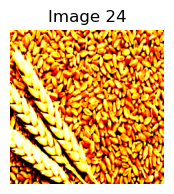

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


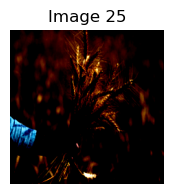

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


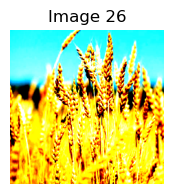

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


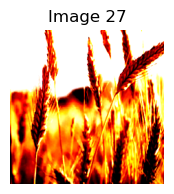

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


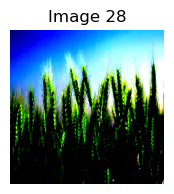

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


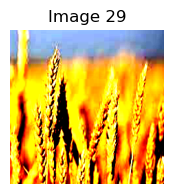

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


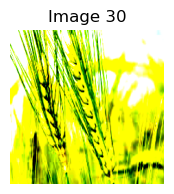

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


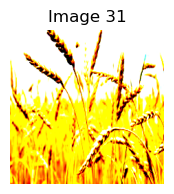

In [5]:
# Plot each image in curr_images individually:
for index_2, image_2 in enumerate(curr_images_2):

    # Set desired figure size:
    plt.figure(figsize=(2, 2))

    # Rearrange dimensions from tensor format so that matplotlib can read image correctly:
    plt.imshow(image_2.permute(1, 2, 0))  

    # Set image title based on current image number:
    plt.title(f"Image {index_2 + 1}")

    # Plot image with axis off:
    plt.axis('off')
    plt.show()

5. Convert data and labels into Tensors and then create dataloader instances for pytorch:

In [6]:
# For first Iteration of dataset (No augmentation)

# Convert training, validation, and testing data into pytorch tensors:
X_train_tensor_1 = torch.stack(combined_X_train_1)
y_train_tensor_1 = torch.tensor(combined_y_train_1)

X_validation_tensor_1 = torch.stack(combined_X_validation_1)
y_validation_tensor_1 = torch.tensor(combined_y_validation_1)

X_test_tensor_1 = torch.stack(combined_X_test_1)
y_test_tensor_1 = torch.tensor(combined_y_test_1)

# Build pytorch tensor dataset objects:
training_dataset_1 = TensorDataset(X_train_tensor_1, y_train_tensor_1)
validation_dataset_1 = TensorDataset(X_validation_tensor_1, y_validation_tensor_1)
testing_dataset_1 = TensorDataset(X_test_tensor_1, y_test_tensor_1)

# Create dataLoader objects which batch (size = 64) and shuffle the training data:
train_loader_1 = DataLoader(training_dataset_1, batch_size=64, shuffle=True)
val_loader_1 = DataLoader(validation_dataset_1, batch_size=64, shuffle=False)
test_loader_1 = DataLoader(testing_dataset_1, batch_size=64, shuffle=False)

In [7]:
# For second Iteration of dataset (Augmentation)

# Convert training, validation, and testing data into pytorch tensors:
X_train_tensor_2 = torch.stack(combined_X_train_2)
y_train_tensor_2 = torch.tensor(combined_y_train_2)

X_validation_tensor_2 = torch.stack(combined_X_validation_2)
y_validation_tensor_2 = torch.tensor(combined_y_validation_2)

X_test_tensor_2 = torch.stack(combined_X_test_2)
y_test_tensor_2 = torch.tensor(combined_y_test_2)

# Build pytorch tensor dataset objects:
training_dataset_2 = TensorDataset(X_train_tensor_2, y_train_tensor_2)
validation_dataset_2 = TensorDataset(X_validation_tensor_2, y_validation_tensor_2)
testing_dataset_2 = TensorDataset(X_test_tensor_2, y_test_tensor_2)

# Create dataLoader objects which batch (size = 64) and shuffle the training data:
train_loader_2 = DataLoader(training_dataset_2, batch_size=64, shuffle=True)
val_loader_2 = DataLoader(validation_dataset_2, batch_size=64, shuffle=False)
test_loader_2 = DataLoader(testing_dataset_2, batch_size=64, shuffle=False)

6. Model Definitions

    - We decided to apply transfer learning using the pre-trained ResNet18 model (trained on ImageNet dataset)
    - Initial weights are loaded in and frozen
    - The final linear layer is applied where these weight are adjusted per epoch
    - GPU will be used if available on computer running the training

In [8]:
# For first Iteration of dataset (No augmentation)

# Instantiate the Resnet18 model using standard weights (did not implement freezing of layers):
model_1 = torchvision.models.resnet18(weights=True)

# Freeze Resnet18 layers:
for parameter_1 in model_1.parameters():
    parameter_1.requires_grad = False

num_ftrs_1 = model_1.fc.in_features   # Define features to use from Resnet18
num_classes_1 = 30                  # Define number of unique classification classes

# Adjust the final fully connected layer based on the number of classes:
# model_1.fc = nn.Linear(num_ftrs_1, num_classes_1)

model_1.fc = nn.Sequential(
    nn.Dropout(0.5),    # Apply dropout
    nn.Linear(num_ftrs_1, num_classes_1)
)

# Check if a GPU is available and move the model to GPU if possible:
device_1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device_1)
model_1 = model_1.to(device_1)

c:\Users\Dillon\anaconda3\envs\enel645\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device used: cpu


In [9]:
# For second Iteration of dataset (Augmentation)

# Instantiate the Resnet18 model using standard weights (did not implement freezing of layers):
model_2 = torchvision.models.resnet18(weights=True)

# Freeze Resnet18 layers:
for parameter_2 in model_2.parameters():
    parameter_2.requires_grad = False

num_ftrs_2 = model_2.fc.in_features   # Define features to use from Resnet18
num_classes_2 = 30                  # Define number of unique classification classes

# Adjust the final fully connected layer based on the number of classes:
# model_2.fc = nn.Linear(num_ftrs_2, num_classes_2)

model_2.fc = nn.Sequential(
    nn.Dropout(0.5),    # Apply dropout
    nn.Linear(num_ftrs_2, num_classes_2)
)

# Check if a GPU is available and move the model to GPU if possible:
device_2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device_2)
model_2 = model_2.to(device_2)

Device used: cpu


7. Loss Function and Optimizer

    - Below, we define out loss function criteria (Cross Entropy) and optimizer (Stochastic Gradient Descent) that are used for learning. 
    - We played with the learning rate and momentum parameters in the optimizer, which resulted in the following results from initial tests:

In [10]:
# For first Iteration of dataset (No augmentation)

# We use CrossEntropy loss function and the SGD optimizer:
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

In [11]:
# For second Iteration of dataset (Augmentation)

# We use CrossEntropy loss function and the SGD optimizer:
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

8. Training Loops:

    - We chose to implement our training loops with validation occuring in each epoch
    - When the validation loss has stopped decreasing onver 3 epochs, the training is terminated
    - the best epoch model is then stored to be used for testing

In [12]:
# For first Iteration of dataset (No augmentation)
print("Training results using the raw dataset (No augmentation):\n")

# Initialize stopping parameters:
no_improvement_count_1 = 0 
best_val_loss_1 = 100000      # Initialize loss to be larger than first expected by a very large number
max_num_epochs_1 = 60         # Code will stop if 60 epochs are reached
patience_1 = 3                # Code will stop if validation loss hasnt decreased for 3 epochs

# Initialize storage for tracking best epoch:
best_epoch_1 = 0
best_epoch_state_1 = None
   

for epoch_1 in range(max_num_epochs_1):

    # Set model to training mode:
    model_1.train()

    # Initialize tracking parameters:
    running_loss_1 = 0.0
    correct_1 = 0
    total_1 = 0

  

    # Training phase:
    for images_1, labels_1 in train_loader_1:
        images_1, labels_1 = images_1.to(device_1), labels_1.to(device_1)

        # Clear gradients from previous epoch:
        optimizer_1.zero_grad()

        # Implement forward pass:
        outputs_1 = model_1(images_1)
        loss_1 = criterion_1(outputs_1, labels_1)

        # Implement backward pass:
        loss_1.backward()
        optimizer_1.step()
        running_loss_1 += loss_1.item()

        # Convert outputs to predicted class labels:
        __1, predicted_1 = torch.max(outputs_1.data, 1)

        # Update count of processed labels and correctly predicted labels:
        total_1 += labels_1.size(0)
        correct_1 += (predicted_1 == labels_1).sum().item()

    # Calculate training loss and accuracy for current epoch:
    train_loss_1 = running_loss_1 / len(train_loader_1)
    train_acc_1 = 100 * correct_1 / total_1

    # Validation phase:

    # Set the model to evaluation mode:
    model_1.eval()

    # Initialize tracking parameters:
    val_running_loss_1 = 0.0
    val_correct_1 = 0
    val_total_1 = 0

    # Iterate through batches without tracking gradients:
    with torch.no_grad():
        for images_1, labels_1 in val_loader_1:
            images_1, labels_1 = images_1.to(device_1), labels_1.to(device_1)
            outputs_1 = model_1(images_1)
            loss_1 = criterion_1(outputs_1, labels_1)
            val_running_loss_1 += loss_1.item()

            # Convert outputs to predicted class labels:
            __1, predicted_1 = torch.max(outputs_1.data, 1)

            # Update count of processed labels and correctly predicted labels:
            val_total_1 += labels_1.size(0)
            val_correct_1 += (predicted_1 == labels_1).sum().item()

    # Calculate validation loss and accuracy for current epoch:
    val_loss_1 = val_running_loss_1 / len(val_loader_1)
    val_acc_1 = 100 * val_correct_1 / val_total_1

    # Add a stop condition based on validation loss:
    if val_loss_1 < best_val_loss_1:
        best_val_loss_1 = val_loss_1
        no_improvement_count_1 = 0

        # Store current epoch as 'best epoch' for running model on test data:
        best_epoch_1 = epoch_1
        best_epoch_state_1 = model_1.state_dict()
    else:
        no_improvement_count_1 = no_improvement_count_1 + 1

    # Evaluate if stop condition has not decreased based on set patience:
    if no_improvement_count_1 >= patience_1:
        break

    # Output current epoch losses and accuracies:
    print(f'Epoch {epoch_1+1}, Train Loss: {train_loss_1:.4f}, Train Accuracy: {train_acc_1:.2f}%, Val Loss: {val_loss_1:.4f}, Val Accuracy: {val_acc_1:.2f}%')

print("The best epoch for this model was epoch: ", best_epoch_1)


Training results using the raw dataset (No augmentation):

Epoch 1, Train Loss: 3.7531, Train Accuracy: 4.14%, Val Loss: 3.5398, Val Accuracy: 5.06%
Epoch 2, Train Loss: 3.5014, Train Accuracy: 6.90%, Val Loss: 3.4248, Val Accuracy: 10.13%
Epoch 3, Train Loss: 3.3255, Train Accuracy: 9.05%, Val Loss: 3.3153, Val Accuracy: 13.92%
Epoch 4, Train Loss: 3.1233, Train Accuracy: 13.65%, Val Loss: 3.1117, Val Accuracy: 16.46%
Epoch 5, Train Loss: 2.9158, Train Accuracy: 19.02%, Val Loss: 2.9297, Val Accuracy: 26.58%
Epoch 6, Train Loss: 2.8205, Train Accuracy: 22.55%, Val Loss: 2.7896, Val Accuracy: 30.38%
Epoch 7, Train Loss: 2.6612, Train Accuracy: 28.68%, Val Loss: 2.6898, Val Accuracy: 34.18%
Epoch 8, Train Loss: 2.5286, Train Accuracy: 33.74%, Val Loss: 2.6033, Val Accuracy: 46.84%
Epoch 9, Train Loss: 2.4044, Train Accuracy: 39.57%, Val Loss: 2.5206, Val Accuracy: 44.30%
Epoch 10, Train Loss: 2.2805, Train Accuracy: 41.72%, Val Loss: 2.3961, Val Accuracy: 50.63%
Epoch 11, Train Loss: 2.

In [13]:
# For second Iteration of dataset (Augmentation)
print("Training results using the augmented dataset:\n")

# Initialize stopping parameters:
no_improvement_count_2 = 0 
best_val_loss_2 = 100000      # Initialize loss to be larger than first expected by a very large number
max_num_epochs_2 = 60         # Code will stop if 60 epochs are reached
patience_2 = 3                # Code will stop if validation loss hasnt decreased for 3 epochs

# Initialize storage for tracking best epoch:
best_epoch_2 = 0
best_epoch_state_2 = None
   

for epoch_2 in range(max_num_epochs_2):

    # Set model to training mode:
    model_2.train()

    # Initialize tracking parameters:
    running_loss_2 = 0.0
    correct_2 = 0
    total_2 = 0

  

    # Training phase:
    for images_2, labels_2 in train_loader_2:
        images_2, labels_2 = images_2.to(device_2), labels_2.to(device_2)

        # Clear gradients from previous epoch:
        optimizer_2.zero_grad()

        # Implement forward pass:
        outputs_2 = model_2(images_2)
        loss_2 = criterion_2(outputs_2, labels_2)

        # Implement backward pass:
        loss_2.backward()
        optimizer_2.step()
        running_loss_2 += loss_2.item()

        # Convert outputs to predicted class labels:
        __2, predicted_2 = torch.max(outputs_2.data, 1)

        # Update count of processed labels and correctly predicted labels:
        total_2 += labels_2.size(0)
        correct_2 += (predicted_2 == labels_2).sum().item()

    # Calculate training loss and accuracy for current epoch:
    train_loss_2 = running_loss_2 / len(train_loader_2)
    train_acc_2 = 100 * correct_2 / total_2

    # Validation phase:

    # Set the model to evaluation mode:
    model_2.eval()

    # Initialize tracking parameters:
    val_running_loss_2 = 0.0
    val_correct_2 = 0
    val_total_2 = 0

    # Iterate through batches without tracking gradients:
    with torch.no_grad():
        for images_2, labels_2 in val_loader_2:
            images_2, labels_2 = images_2.to(device_2), labels_2.to(device_2)
            outputs_2 = model_2(images_2)
            loss_2 = criterion_2(outputs_2, labels_2)
            val_running_loss_2 += loss_2.item()

            # Convert outputs to predicted class labels:
            __2, predicted_2 = torch.max(outputs_2.data, 1)

            # Update count of processed labels and correctly predicted labels:
            val_total_2 += labels_2.size(0)
            val_correct_2 += (predicted_2 == labels_2).sum().item()

    # Calculate validation loss and accuracy for current epoch:
    val_loss_2 = val_running_loss_2 / len(val_loader_2)
    val_acc_2 = 100 * val_correct_2 / val_total_2

    # Add a stop condition based on validation loss:
    if val_loss_2 < best_val_loss_2:
        best_val_loss_2 = val_loss_2
        no_improvement_count_2 = 0

        # Store current epoch as 'best epoch' for running model on test data:
        best_epoch_2 = epoch_2
        best_epoch_state_2 = model_2.state_dict()
    else:
        no_improvement_count_2 = no_improvement_count_2 + 1

    # Evaluate if stop condition has not decreased based on set patience:
    if no_improvement_count_2 >= patience_2:
        break

    # Output current epoch losses and accuracies:
    print(f'Epoch {epoch_2+1}, Train Loss: {train_loss_2:.4f}, Train Accuracy: {train_acc_2:.2f}%, Val Loss: {val_loss_2:.4f}, Val Accuracy: {val_acc_2:.2f}%')

print("The best epoch for this model was epoch: ", best_epoch_2)

Training results using the augmented dataset:

Epoch 1, Train Loss: 3.6106, Train Accuracy: 4.36%, Val Loss: 3.1928, Val Accuracy: 14.97%
Epoch 2, Train Loss: 3.3158, Train Accuracy: 7.99%, Val Loss: 2.9244, Val Accuracy: 22.16%
Epoch 3, Train Loss: 3.1255, Train Accuracy: 13.48%, Val Loss: 2.7372, Val Accuracy: 29.34%
Epoch 4, Train Loss: 2.9419, Train Accuracy: 17.91%, Val Loss: 2.5876, Val Accuracy: 35.93%
Epoch 5, Train Loss: 2.7982, Train Accuracy: 21.96%, Val Loss: 2.4499, Val Accuracy: 41.32%
Epoch 6, Train Loss: 2.6693, Train Accuracy: 24.97%, Val Loss: 2.3418, Val Accuracy: 41.92%
Epoch 7, Train Loss: 2.5812, Train Accuracy: 29.25%, Val Loss: 2.2676, Val Accuracy: 43.71%
Epoch 8, Train Loss: 2.5077, Train Accuracy: 30.64%, Val Loss: 2.1764, Val Accuracy: 44.91%
Epoch 9, Train Loss: 2.4420, Train Accuracy: 33.12%, Val Loss: 2.1177, Val Accuracy: 45.51%
Epoch 10, Train Loss: 2.3986, Train Accuracy: 33.30%, Val Loss: 2.0501, Val Accuracy: 48.50%
Epoch 11, Train Loss: 2.3150, Trai

9. Defining Model Testing functions:
    - Weights from the best epoch during training are loaded in before evaluating testing datasets

In [14]:
# For first Iteration of dataset (No augmentation)

# Function defined to evaluate both models using our test dataset:
def evaluate_model_1(model_1, data_loader_1, best_epoch_state_1):

    # Set model to evaluate mode
    model_1.eval()

    # Load the best epoch state that was determined through training and validation stage:
    model_1.load_state_dict(best_epoch_state_1)

    # Initialize tracking parameters:
    total_1 = 0
    correct_1 = 0
    all_preds_1 = []
    all_labels_1 = []

    # Iterate through batches without tracking gradients:
    with torch.no_grad():
        for images_1, labels_1 in data_loader_1:
            images_1, labels_1 = images_1.to(device_1), labels_1.to(device_1)
            outputs_1 = model_1(images_1)

            # Convert outputs to predicted class labels:
            __1, predicted_1 = torch.max(outputs_1, 1)

            # Update count of processed labels and correctly predicted labels:
            total_1 += labels_1.size(0)
            correct_1 += (predicted_1 == labels_1).sum().item()

            # Collect predictions and labels:
            all_preds_1.extend(predicted_1.view(-1).cpu().numpy())
            all_labels_1.extend(labels_1.view(-1).cpu().numpy())

    # Calculate accuracy and return results:
    accuracy_1 = 100 * correct_1 / total_1
    return accuracy_1, all_preds_1, all_labels_1


In [15]:
# For second Iteration of dataset (Augmentation)

# Function defined to evaluate both models using our test dataset:
def evaluate_model_2(model_2, data_loader_2, best_epoch_state_2):

    # Set model to evaluate mode
    model_2.eval()

    # Load the best epoch state that was determined through training and validation stage:
    model_2.load_state_dict(best_epoch_state_2)

    # Initialize tracking parameters:
    total_2 = 0
    correct_2 = 0
    all_preds_2 = []
    all_labels_2 = []

    # Iterate through batches without tracking gradients:
    with torch.no_grad():
        for images_2, labels_2 in data_loader_2:
            images_2, labels_2 = images_2.to(device_2), labels_2.to(device_2)
            outputs_2 = model_2(images_2)

            # Convert outputs to predicted class labels:
            __2, predicted_2 = torch.max(outputs_2, 1)

            # Update count of processed labels and correctly predicted labels:
            total_2 += labels_2.size(0)
            correct_2 += (predicted_2 == labels_2).sum().item()

            # Collect predictions and labels:
            all_preds_2.extend(predicted_2.view(-1).cpu().numpy())
            all_labels_2.extend(labels_2.view(-1).cpu().numpy())

    # Calculate accuracy and return results:
    accuracy_2 = 100 * correct_2 / total_2
    return accuracy_2, all_preds_2, all_labels_2


10. Evaluation Metrics and Testing:

    - Below is our blocks of code that evaluate the models using the testing data
    - We focused on evaluating the model using metrics such as accuracy, precision, recall, and f-score
    - We also presented the confusion matrix showing insight into how the results looked for each class

Test Accuracy: 68.37%
['almond', 'banana', 'cardamom', 'Cherry', 'chilli', 'clove', 'coconut', 'Coffee-plant', 'cotton', 'Cucumber', 'Fox_nut(Makhana)', 'gram', 'jowar', 'jute', 'Lemon', 'maize', 'mustard-oil', 'Olive-tree', 'papaya', 'Pearl_millet(bajra)', 'pineapple', 'rice', 'soyabean', 'sugarcane', 'sunflower', 'tea', 'Tobacco-plant', 'tomato', 'vigna-radiati(Mung)', 'wheat']


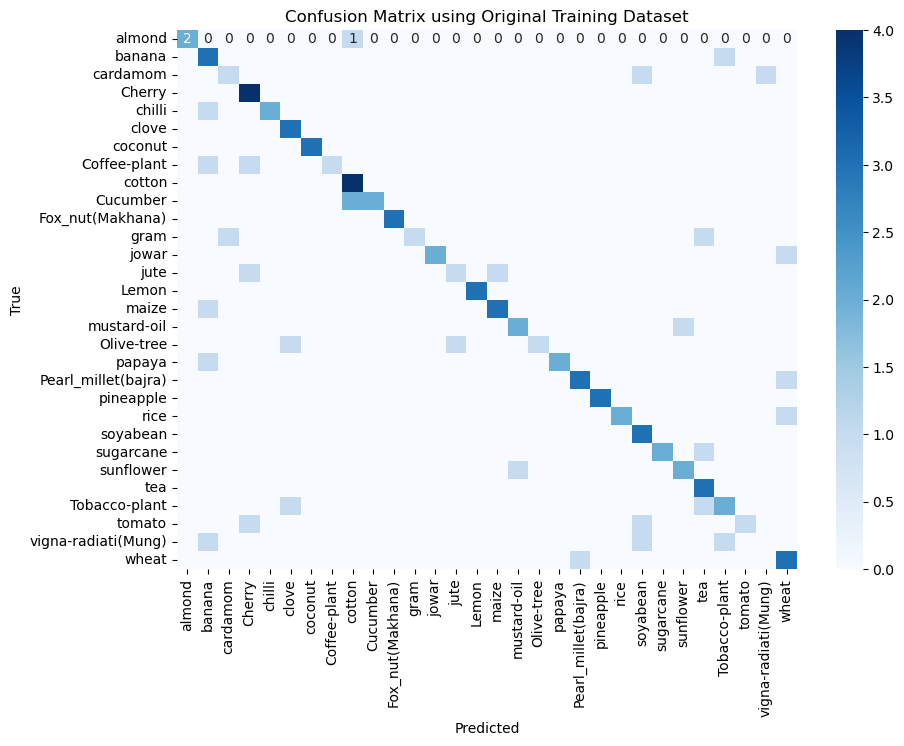

                     precision    recall  f1-score   support

             almond       1.00      0.67      0.80         3
             banana       0.38      0.75      0.50         4
           cardamom       0.50      0.33      0.40         3
             Cherry       0.57      1.00      0.73         4
             chilli       1.00      0.67      0.80         3
              clove       0.60      1.00      0.75         3
            coconut       1.00      1.00      1.00         3
       Coffee-plant       1.00      0.33      0.50         3
             cotton       0.57      1.00      0.73         4
           Cucumber       1.00      0.50      0.67         4
   Fox_nut(Makhana)       1.00      1.00      1.00         3
               gram       1.00      0.33      0.50         3
              jowar       1.00      0.67      0.80         3
               jute       0.50      0.33      0.40         3
              Lemon       1.00      1.00      1.00         3
              maize    

In [16]:
# For first Iteration of dataset (No augmentation)

# Evaluate test dataset using function defined in block above:
test_accuracy_1, test_preds_1, test_labels_1 = evaluate_model_1(model_1, test_loader_1, best_epoch_state_1)
print(f'Test Accuracy: {test_accuracy_1:.2f}%')

# Get class names:
print(classifications_list_1)

# Define and plot confusion Matrix:
cm_1 = confusion_matrix(test_labels_1, test_preds_1)
class_names_1 = classifications_list_1
plt.figure(figsize=(10,7))
sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_1, yticklabels=class_names_1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Original Training Dataset')
plt.show()

# Output classification Report:
print(classification_report(test_labels_1, test_preds_1, target_names=class_names_1))


Test Accuracy: 59.32%
['almond', 'banana', 'cardamom', 'Cherry', 'chilli', 'clove', 'coconut', 'Coffee-plant', 'cotton', 'Cucumber', 'Fox_nut(Makhana)', 'gram', 'jowar', 'jute', 'Lemon', 'maize', 'mustard-oil', 'Olive-tree', 'papaya', 'Pearl_millet(bajra)', 'pineapple', 'rice', 'soyabean', 'sugarcane', 'sunflower', 'tea', 'Tobacco-plant', 'tomato', 'vigna-radiati(Mung)', 'wheat']


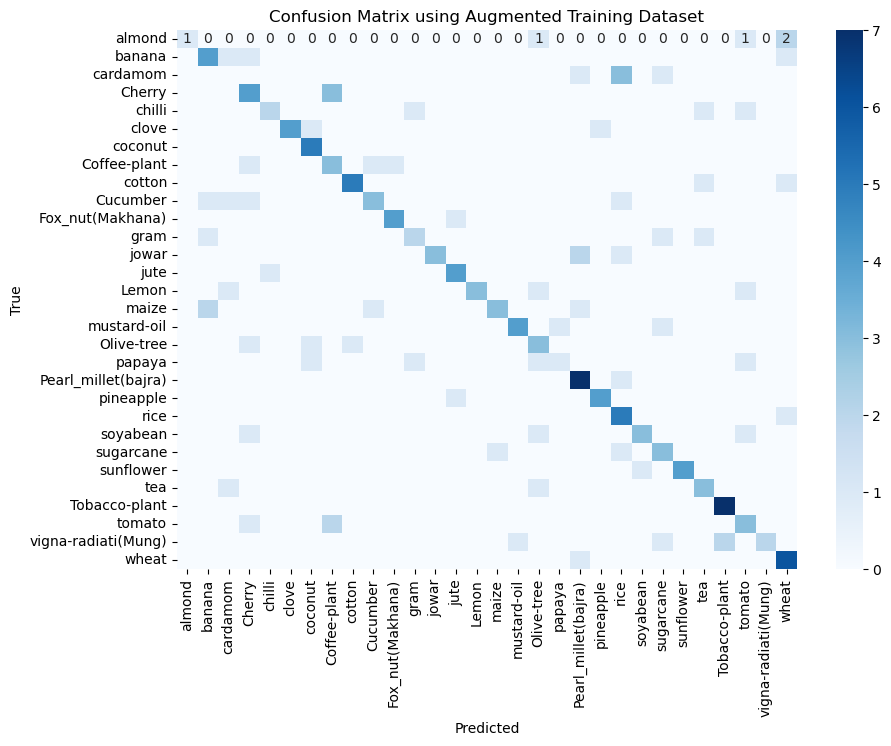

                     precision    recall  f1-score   support

             almond       1.00      0.20      0.33         5
             banana       0.50      0.57      0.53         7
           cardamom       0.00      0.00      0.00         5
             Cherry       0.40      0.57      0.47         7
             chilli       0.67      0.40      0.50         5
              clove       1.00      0.67      0.80         6
            coconut       0.62      1.00      0.77         5
       Coffee-plant       0.38      0.50      0.43         6
             cotton       0.83      0.71      0.77         7
           Cucumber       0.60      0.43      0.50         7
   Fox_nut(Makhana)       0.80      0.80      0.80         5
               gram       0.50      0.40      0.44         5
              jowar       1.00      0.50      0.67         6
               jute       0.67      0.80      0.73         5
              Lemon       1.00      0.50      0.67         6
              maize    

In [17]:
# For second Iteration of dataset (Augmentation)

# Evaluate test dataset using function defined in block above:
test_accuracy_2, test_preds_2, test_labels_2 = evaluate_model_2(model_2, test_loader_2, best_epoch_state_2)
print(f'Test Accuracy: {test_accuracy_2:.2f}%')

# Get class names:
print(classifications_list_2)

# Define and plot confusion Matrix:
cm_2 = confusion_matrix(test_labels_2, test_preds_2)
class_names_2 = classifications_list_2
plt.figure(figsize=(10,7))
sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_2, yticklabels=class_names_2)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix using Augmented Training Dataset')
plt.show()

# Output classification Report:
print(classification_report(test_labels_2, test_preds_2, target_names=class_names_2))
